# Import Library

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess

2024-10-13 05:15:55.084600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-13 05:15:55.084644: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-13 05:15:55.084677: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-13 05:15:55.122744: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Explanatory Data Analysis

In [2]:
not_trainable = pd.read_csv('outputs/results_not_trainable.csv')
trainable = pd.read_csv('outputs/results_trainable.csv')

In [3]:
not_trainable_sorted = not_trainable.sort_values(by='Test Accuracy', ascending=False)
not_trainable_sorted

,Model,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Loss,Test Accuracy,Training Duration,Total Epoch
5,EfficientNetB5,0.958032,0.113112,0.936782,0.196974,0.622120,0.797647,1526.488535,18
3,EfficientNetB3,0.926917,0.189006,0.933908,0.212490,0.609218,0.776078,1526.488535,18
1,EfficientNetB1,0.917511,0.226357,0.882184,0.306373,0.663236,0.759216,1526.488535,18
6,EfficientNetB6,0.965268,0.094941,0.942529,0.141136,1.036159,0.754118,1526.488535,18
2,EfficientNetB2,0.897974,0.260599,0.890805,0.272235,0.665238,0.745882,1526.488535,18
4,EfficientNetB4,0.938495,0.176494,0.931035,0.182656,0.797472,0.732549,1526.488535,18
0,EfficientNetB0,0.923300,0.224197,0.887931,0.309241,0.980673,0.716471,1526.488535,18
7,EfficientNetB7,0.952967,0.134530,0.919540,0.227406,1.437082,0.709020,1526.488535,18


In [5]:
not_trainable_sorted
highest_train_accuracy_model = not_trainable_sorted.loc[not_trainable_sorted['Train Accuracy'].idxmax(), 'Model']
highest_validation_accuracy_model = not_trainable_sorted.loc[not_trainable_sorted['Validation Accuracy'].idxmax(), 'Model']
highest_test_accuracy_model = not_trainable_sorted.loc[not_trainable_sorted['Test Accuracy'].idxmax(), 'Model']
lowest_training_duration_model = not_trainable_sorted.loc[not_trainable_sorted['Training Duration'].idxmin(), 'Model']
lowest_total_epoch_model = not_trainable_sorted.loc[not_trainable_sorted['Total Epoch'].idxmin(), 'Model']

print("Model dengan Akurasi Pelatihan Tertinggi:", highest_train_accuracy_model)
print("Model dengan Akurasi Validasi Tertinggi:", highest_validation_accuracy_model)
print("Model dengan Akurasi Uji Tertinggi:", highest_test_accuracy_model)
print("Model dengan Durasi Pelatihan Terendah:", lowest_training_duration_model)
print("Model dengan Total Epoch Terendah:", lowest_total_epoch_model)

Model dengan Akurasi Pelatihan Tertinggi: EfficientNetB6
Model dengan Akurasi Validasi Tertinggi: EfficientNetB6
Model dengan Akurasi Uji Tertinggi: EfficientNetB5
Model dengan Durasi Pelatihan Terendah: EfficientNetB5
Model dengan Total Epoch Terendah: EfficientNetB5


In [6]:
trainable_sorted = trainable.sort_values(by='Test Accuracy', ascending=False)
trainable_sorted

,Model,Train Accuracy,Train Loss,Validation Accuracy,Validation Loss,Test Loss,Test Accuracy,Training Duration,Total Epoch
0,EfficientNetB0,0.904486,0.258503,0.902299,0.259506,0.953657,1056.849794,2206.455527,26
3,EfficientNetB3,0.964544,0.110190,0.945402,0.138997,0.413621,0.840392,2206.455527,26
7,EfficientNetB7,0.993488,0.039941,0.979885,0.077881,0.764046,0.818431,2206.455527,26
4,EfficientNetB4,0.982634,0.061023,0.962644,0.100997,0.795683,0.806275,2206.455527,26
5,EfficientNetB5,0.986252,0.042780,0.968391,0.127252,0.864044,0.778431,2206.455527,26
6,EfficientNetB6,0.983357,0.058528,0.954023,0.127000,0.871808,0.746275,2206.455527,26
2,EfficientNetB2,0.942113,0.159752,0.899425,0.250371,0.763945,0.727059,2206.455527,26
1,EfficientNetB1,0.932706,0.191718,0.908046,0.267096,0.951960,0.710588,2206.455527,26


In [7]:
trainable_sorted
highest_train_accuracy_model = trainable_sorted.loc[trainable_sorted['Train Accuracy'].idxmax(), 'Model']
highest_validation_accuracy_model = trainable_sorted.loc[trainable_sorted['Validation Accuracy'].idxmax(), 'Model']
highest_test_accuracy_model = trainable_sorted.loc[trainable_sorted['Test Accuracy'].idxmax(), 'Model']
lowest_training_duration_model = trainable_sorted.loc[trainable_sorted['Training Duration'].idxmin(), 'Model']
lowest_total_epoch_model = trainable_sorted.loc[trainable_sorted['Total Epoch'].idxmin(), 'Model']

print("Model dengan Akurasi Pelatihan Tertinggi:", highest_train_accuracy_model)
print("Model dengan Akurasi Validasi Tertinggi:", highest_validation_accuracy_model)
print("Model dengan Akurasi Uji Tertinggi:", highest_test_accuracy_model)
print("Model dengan Durasi Pelatihan Terendah:", lowest_training_duration_model)
print("Model dengan Total Epoch Terendah:", lowest_total_epoch_model)

Model dengan Akurasi Pelatihan Tertinggi: EfficientNetB7
Model dengan Akurasi Validasi Tertinggi: EfficientNetB7
Model dengan Akurasi Uji Tertinggi: EfficientNetB0
Model dengan Durasi Pelatihan Terendah: EfficientNetB0
Model dengan Total Epoch Terendah: EfficientNetB0


# Melakukan test terhadap dataset test yang sudah di downsample

In [2]:
model_path_not_trainable = 'best_model_not_trainable/best_model_EfficientNetB5.h5'
model_path_trainable = 'best_model_trainable/best_model_EfficientNetB3.h5'
model_not_trainable = load_model(model_path_not_trainable)
model_trainable = load_model(model_path_trainable)

test_dir_balanced = 'data/split_train_test_dataset_campuran_balanced_test'

## Model not_trainable_B5

Found 825 images belonging to 3 classes.
26/26 [==============================] - 271s 10s/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.60      0.97      0.74       275
        rust       0.86      0.30      0.44       275
        scab       0.46      0.48      0.47       275

    accuracy                           0.58       825
   macro avg       0.64      0.58      0.55       825
weighted avg       0.64      0.58      0.55       825



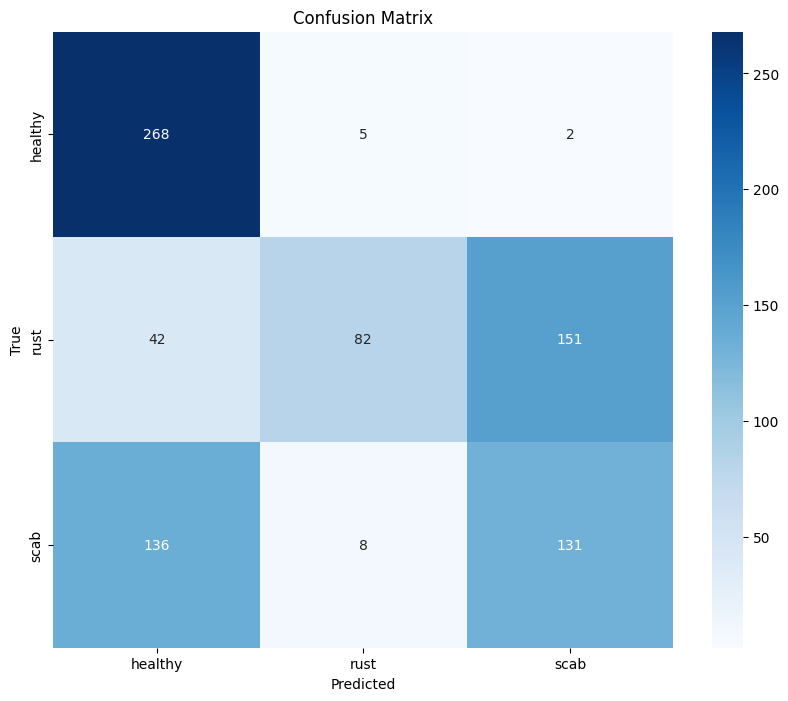

In [16]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_balanced,
    target_size=(456, 456),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_not_trainable.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model trainable B3

Found 825 images belonging to 3 classes.
26/26 [==============================] - 59s 2s/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.82      0.90      0.85       275
        rust       0.96      0.51      0.67       275
        scab       0.59      0.81      0.68       275

    accuracy                           0.74       825
   macro avg       0.79      0.74      0.73       825
weighted avg       0.79      0.74      0.73       825



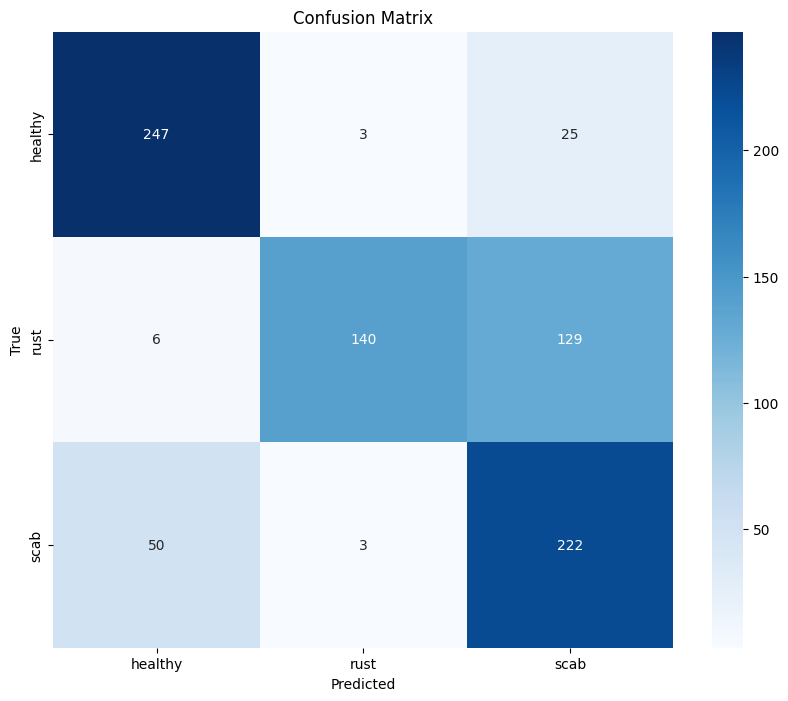

In [17]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_balanced,
    target_size=(300, 300),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_trainable.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Melakukan test terhadap dataset test segmented

In [4]:
#Mendownload dataset
!gdown 18ZCMYEkaTHlNFPzwR7Yp9M7fMEr6KG_p -O data/dataset_cadangan_segmented.zip

#Melakukan unzip file dataset
!unzip -q data/dataset_cadangan_segmented.zip -d data/

#Menghapus file zip
!rm -rf data/dataset_cadangan_segmented.zip

#Rename nama folder
!mv data/test data/dataset_cadangan_segmented 

Downloading...
From: https://drive.google.com/uc?id=18ZCMYEkaTHlNFPzwR7Yp9M7fMEr6KG_p
To: /workspace/TelU-Tubes-TugasAkhir-KlasifikasiPenyakitTanamanApel/data/dataset_cadangan_segmented.zip
100%|███████████████████████████████████████| 22.6M/22.6M [00:00<00:00, 105MB/s]


In [9]:
test_dir_segmentated = 'data/dataset_cadangan_segmented'

## Model not_trainable B5

Found 2550 images belonging to 3 classes.
80/80 [==============================] - 787s 10s/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.88      0.90      0.89      1645
        rust       0.47      0.50      0.48       275
        scab       0.74      0.67      0.70       630

    accuracy                           0.80      2550
   macro avg       0.70      0.69      0.69      2550
weighted avg       0.80      0.80      0.80      2550



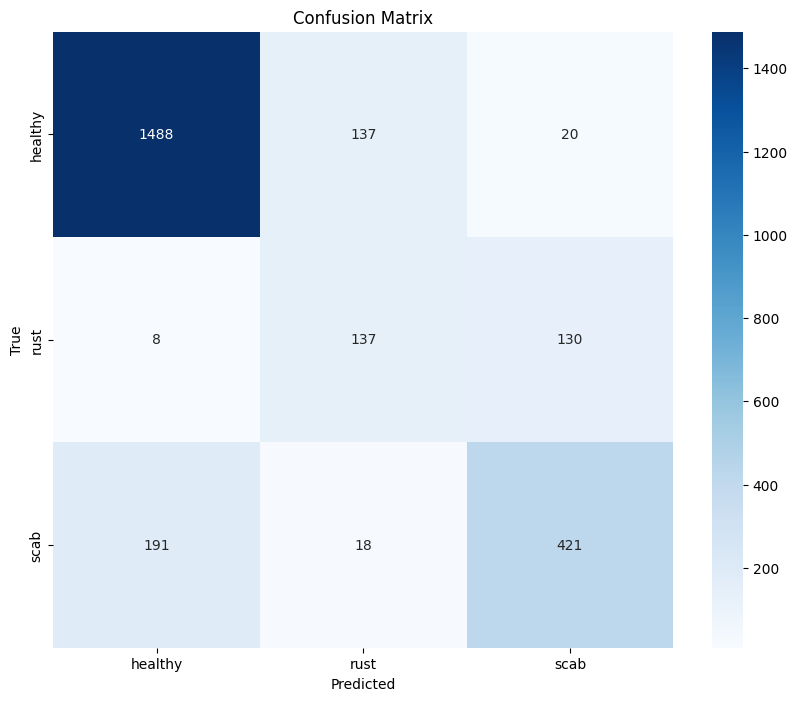

In [12]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_segmentated,
    target_size=(456, 456),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_not_trainable.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Found 2550 images belonging to 3 classes.
80/80 [==============================] - 245s 3s/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.92      0.90      0.91      1645
        rust       0.61      0.34      0.44       275
        scab       0.61      0.76      0.68       630

    accuracy                           0.80      2550
   macro avg       0.71      0.67      0.67      2550
weighted avg       0.81      0.80      0.80      2550



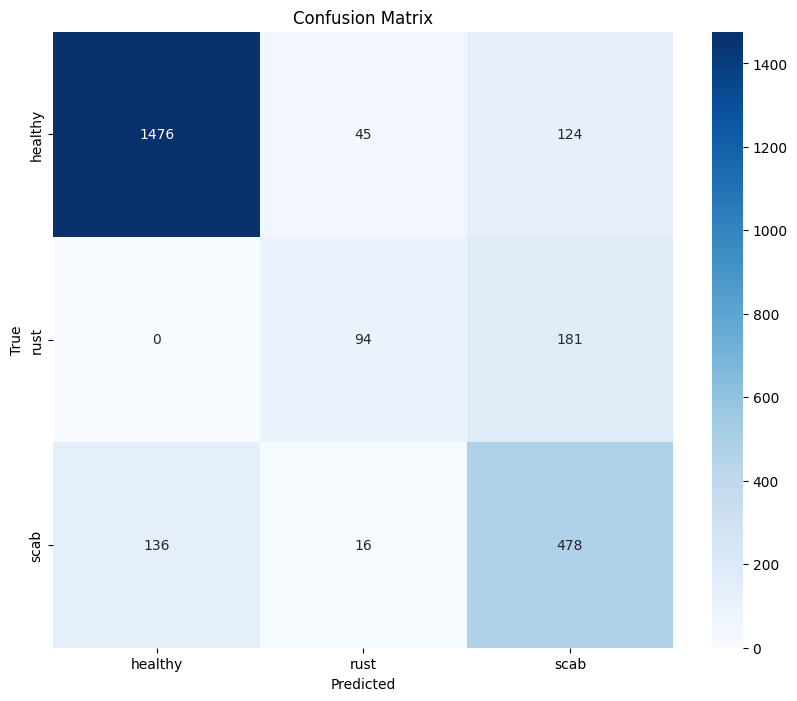

In [4]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_segmentated,
    target_size=(256, 256),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_not_trainable.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model trainable B3

Found 2550 images belonging to 3 classes.
80/80 [==============================] - 171s 2s/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.95      0.79      0.86      1645
        rust       0.86      0.58      0.70       275
        scab       0.55      0.86      0.67       630

    accuracy                           0.78      2550
   macro avg       0.79      0.74      0.74      2550
weighted avg       0.84      0.78      0.80      2550



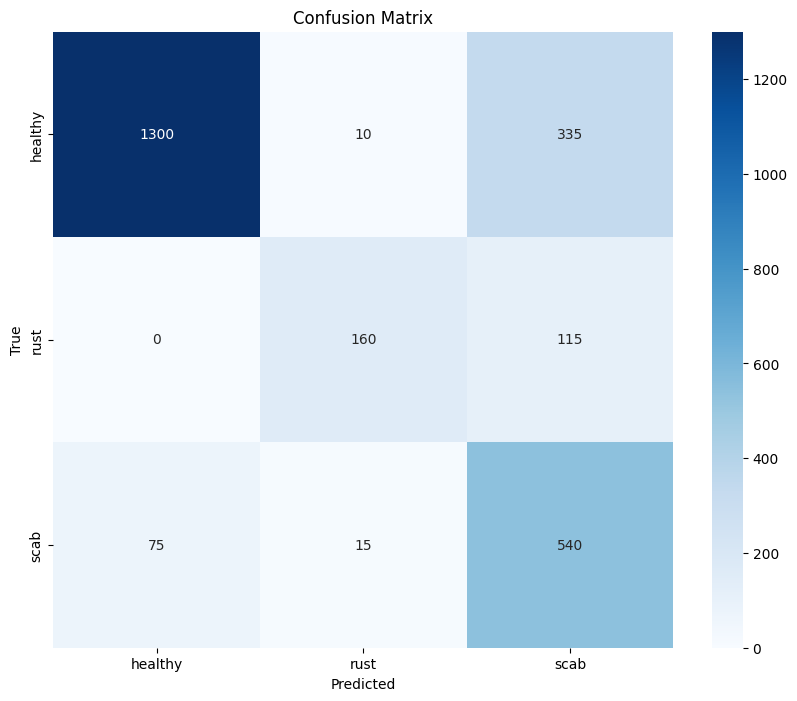

In [5]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_segmentated,
    target_size=(300, 300),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_trainable.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Found 2550 images belonging to 3 classes.
80/80 [==============================] - 123s 2s/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.94      0.77      0.84      1645
        rust       0.65      0.71      0.68       275
        scab       0.53      0.77      0.63       630

    accuracy                           0.76      2550
   macro avg       0.71      0.75      0.72      2550
weighted avg       0.81      0.76      0.77      2550



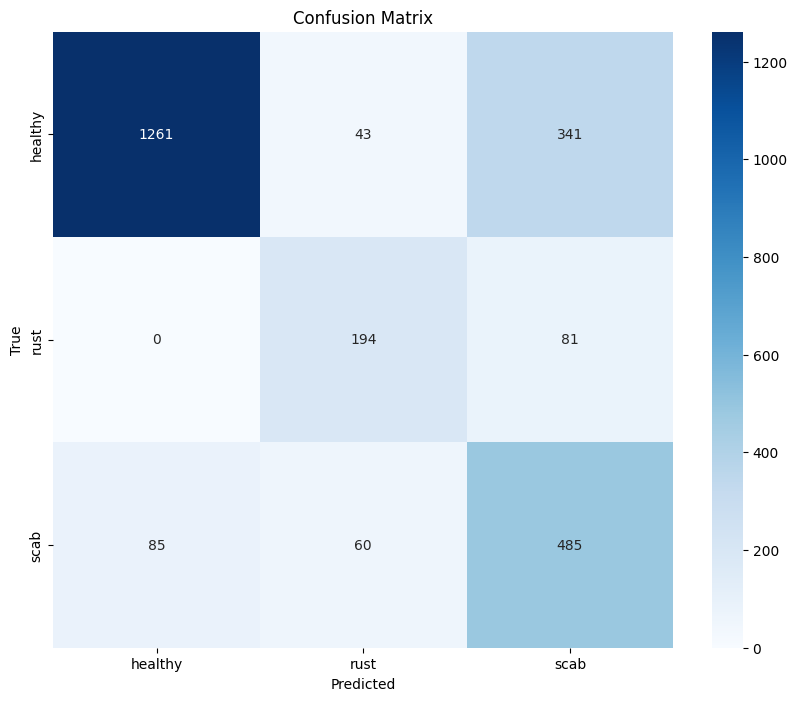

In [6]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_segmentated,
    target_size=(256, 256),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_trainable.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## Model trainable B7

In [2]:
model_trainable_B7 = load_model("best_model_trainable/best_model_EfficientNetB7.h5")

2024-10-13 05:16:06.128615: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22282 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9


Found 2550 images belonging to 3 classes.


2024-10-13 05:19:44.179772: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-10-13 05:19:44.765103: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-13 05:19:44.887987: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


80/80 [==============================] - 11s 79ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.93      0.87      0.90      1645
        rust       0.53      0.03      0.06       275
        scab       0.55      0.85      0.67       630

    accuracy                           0.78      2550
   macro avg       0.67      0.59      0.54      2550
weighted avg       0.79      0.78      0.75      2550



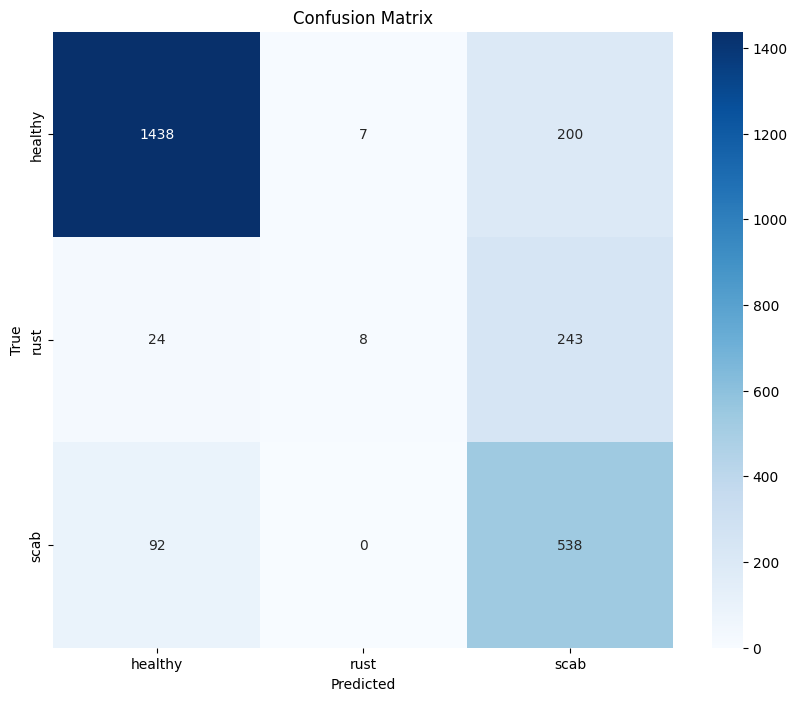

In [10]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_segmentated,
    target_size=(256, 256),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_trainable_B7.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Found 2550 images belonging to 3 classes.
80/80 [==============================] - 40s 500ms/step
Classification Report:
               precision    recall  f1-score   support

     healthy       0.96      0.92      0.94      1645
        rust       0.69      0.03      0.06       275
        scab       0.59      0.90      0.71       630

    accuracy                           0.82      2550
   macro avg       0.75      0.62      0.57      2550
weighted avg       0.84      0.82      0.79      2550



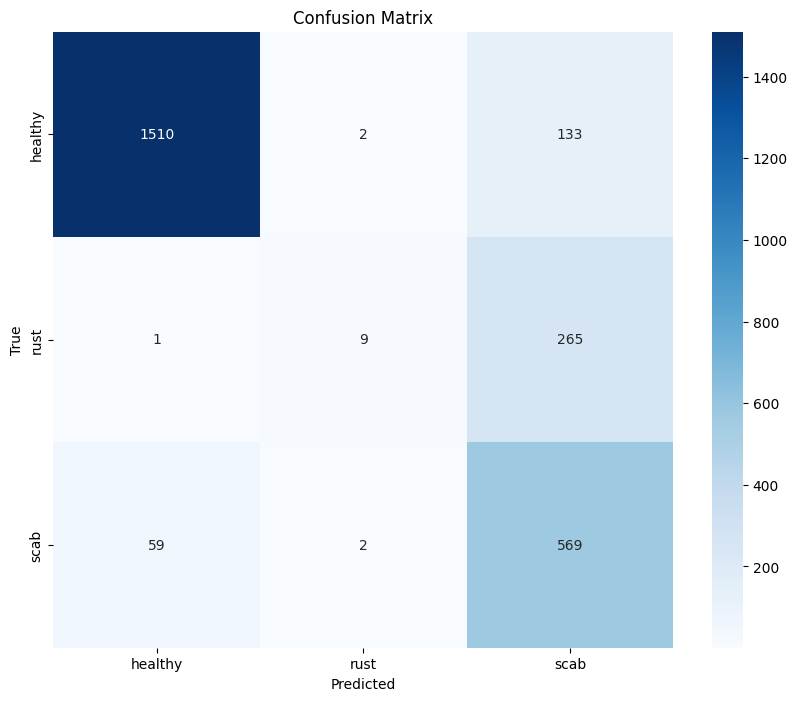

In [11]:
# Menggunakan ImageDataGenerator untuk melakukan preprocessing pada data testing
test_datagen = ImageDataGenerator(preprocessing_function=efficientnet_preprocess)

# Generator untuk data testing
test_generator = test_datagen.flow_from_directory(
    directory=test_dir_segmentated,
    target_size=(600, 600),  # Sesuaikan dengan input size model
    batch_size=32,  # Gunakan batch_size = 1 agar bisa mengambil gambar satu per satu
    class_mode='categorical',
    shuffle=False  # Jangan di-shuffle untuk menjaga urutan gambar
)

y_pred = model_trainable_B7.predict(test_generator, steps=len(test_generator), verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = test_generator.classes

class_names = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_classes)

print("Classification Report:\n", classification_report(y_true, y_pred_classes, target_names=class_names))

# Langkah 5: Menampilkan confusion matrix sebagai heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()